In [30]:
import pandas as pd
import seaborn as sns
from spade_proto.auxiliary import get_data
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style("darkgrid")

In [31]:
def get_eventcodes():
    eventcodes = pd.read_csv('../cameo.csv', header = 0,dtype =str, sep=' *, *', engine='python')
    eventcodes.CAMEOEVENTCODE = eventcodes.CAMEOEVENTCODE.astype('int64')
    return eventcodes

def add_event_descriptions(s):
    eventcodes = get_eventcodes()
    s.EventBaseCode = s.EventBaseCode.astype('int64')
    return s.merge(eventcodes.set_index('CAMEOEVENTCODE'), left_on='EventBaseCode',right_on='CAMEOEVENTCODE', how='left')

async def get_data_with_event_description(QUERY):
    s = await get_data(self, QUERY)
    sm = add_event_descriptions(s)
    return sm

def count_to_percentage_crop(sm, n):
    events_sum = sm.Count.sum()
    smg = sm.groupby("EVENTDESCRIPTION", as_index=False).sum().sort_values(by="Count", ascending=False).head(n)
    if 'Unamed:0' in smg.index.names:
        del smg['Unnamed: 0']
    del smg['EventBaseCode']
    smg.Count = smg.Count.apply(lambda x: x/events_sum*100)
    smg = smg.rename({'Count' :'Percentage'}, axis='columns')
    return smg

async def get_croped_data(QUERY, n):
    sm = await get_data_with_event_description(QUERY)
    smg = count_to_percentage_crop(sm, n)
    return smg

def create_palette_for_event_descriptions(event_descriptions):
    unique = event_descriptions.unique()
    palette = dict(zip(unique, sns.color_palette("Spectral", n_colors=len(unique))))
    return palette

def save_barplot(folder, name, palette, data):
    g = sns.barplot(data=data, x=data.EVENTDESCRIPTION, y=data.Percentage, palette=palette)
    g.set_title(name)
    g.set_xticklabels(g.get_xticklabels(), rotation=60, ha="right")
    g.figure.set_size_inches(20,8)
    plt.savefig(f'{folder}/{name}.png', bbox_inches='tight')
    plt.show()
    plt.close('all')

def update_palette_for_event_descriptions(old_palette, eventsdescription):
    update_palette = create_palette_for_event_descriptions(eventsdescription)
    update_palette.update(old_palette)
    return update_palette

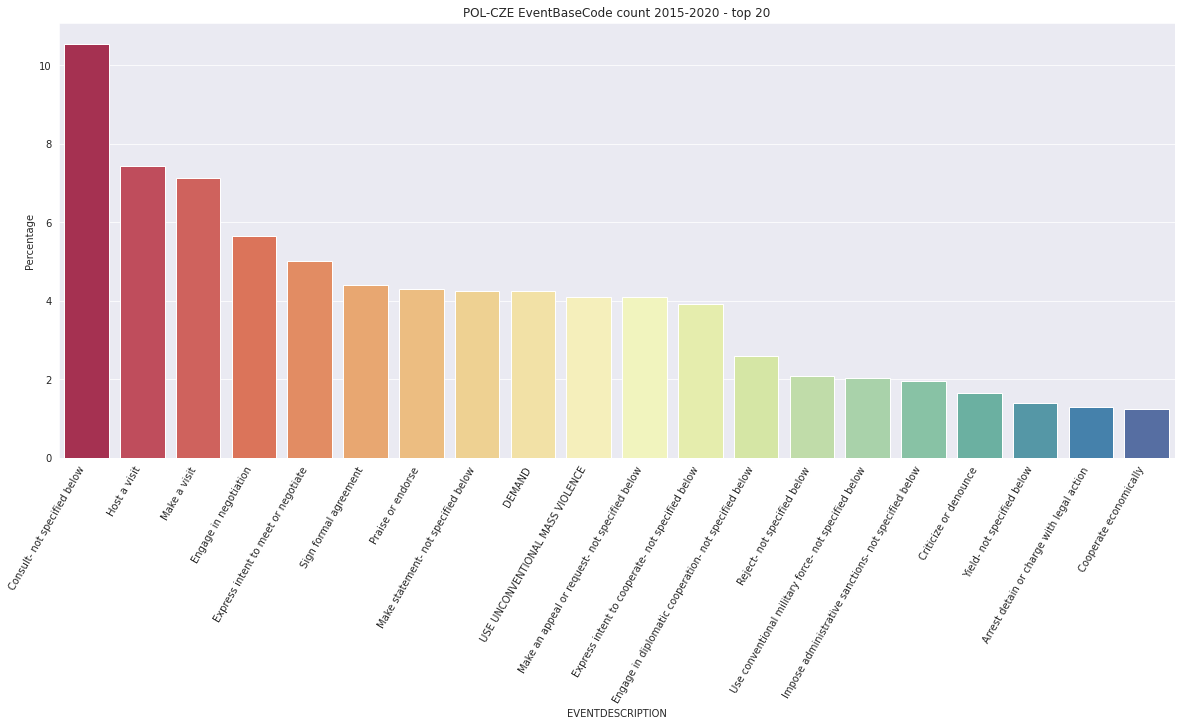

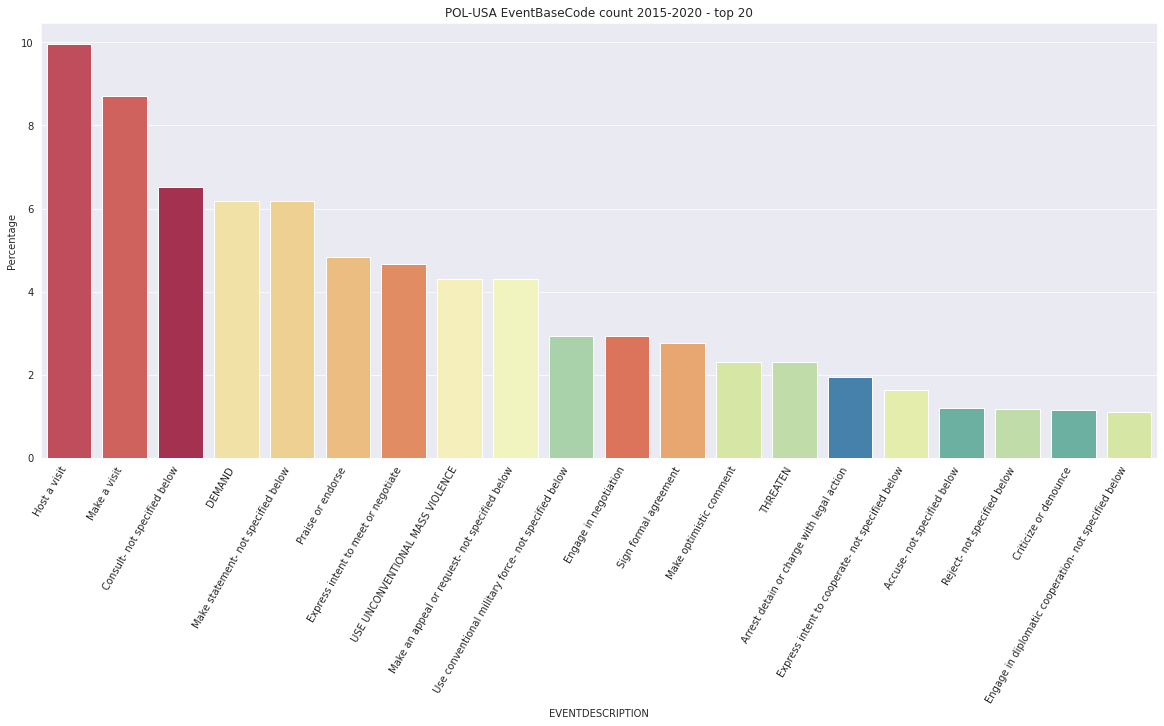

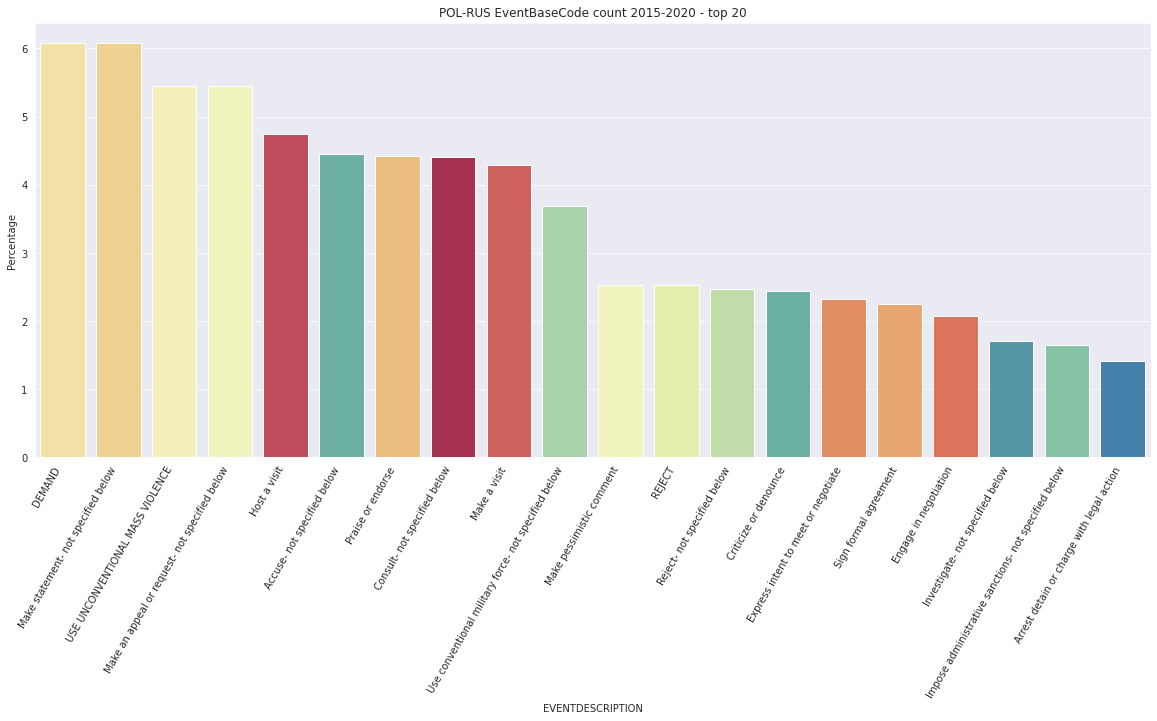

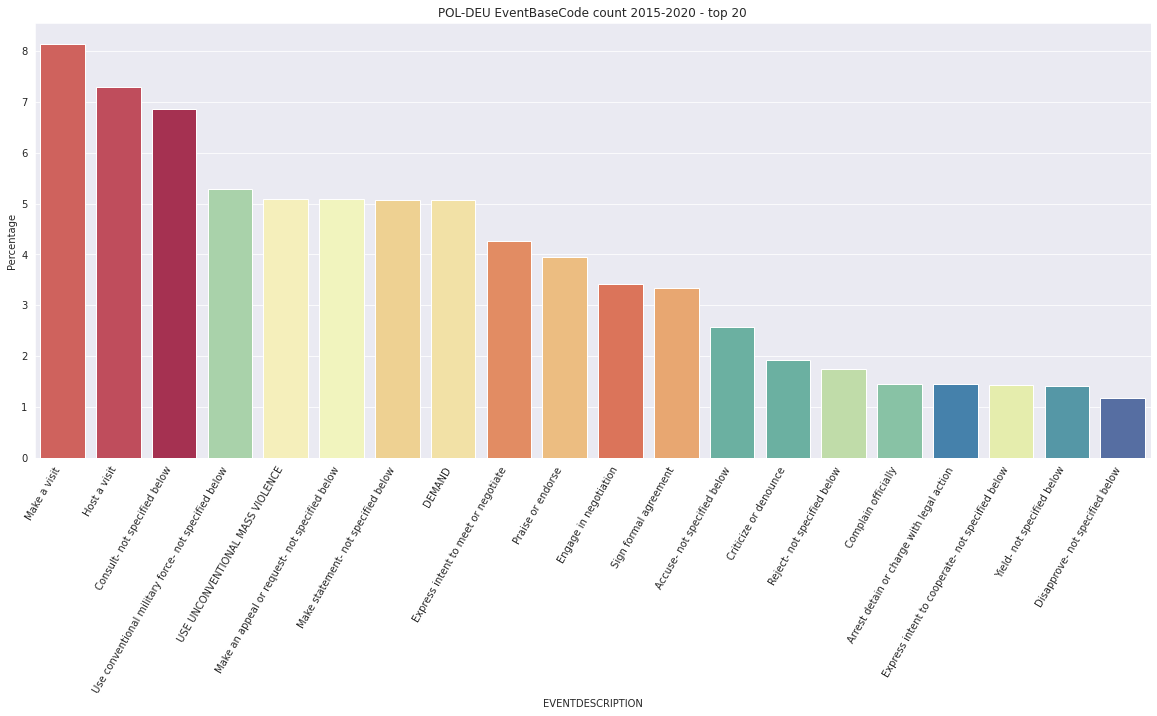

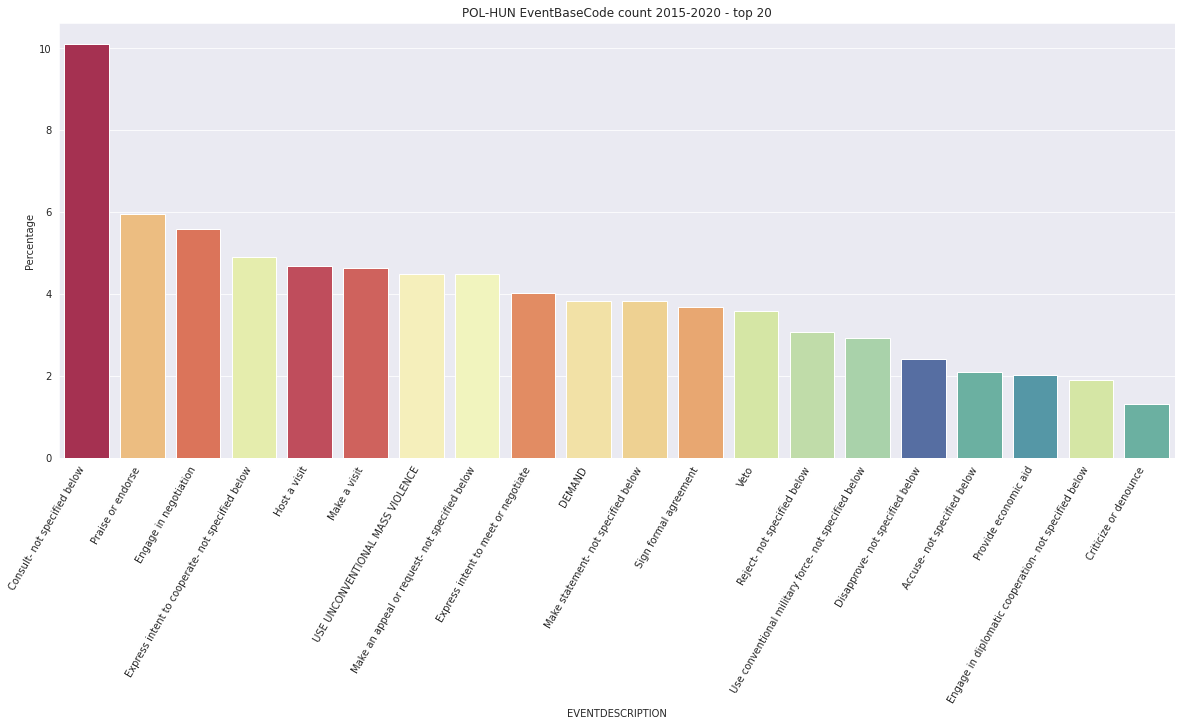

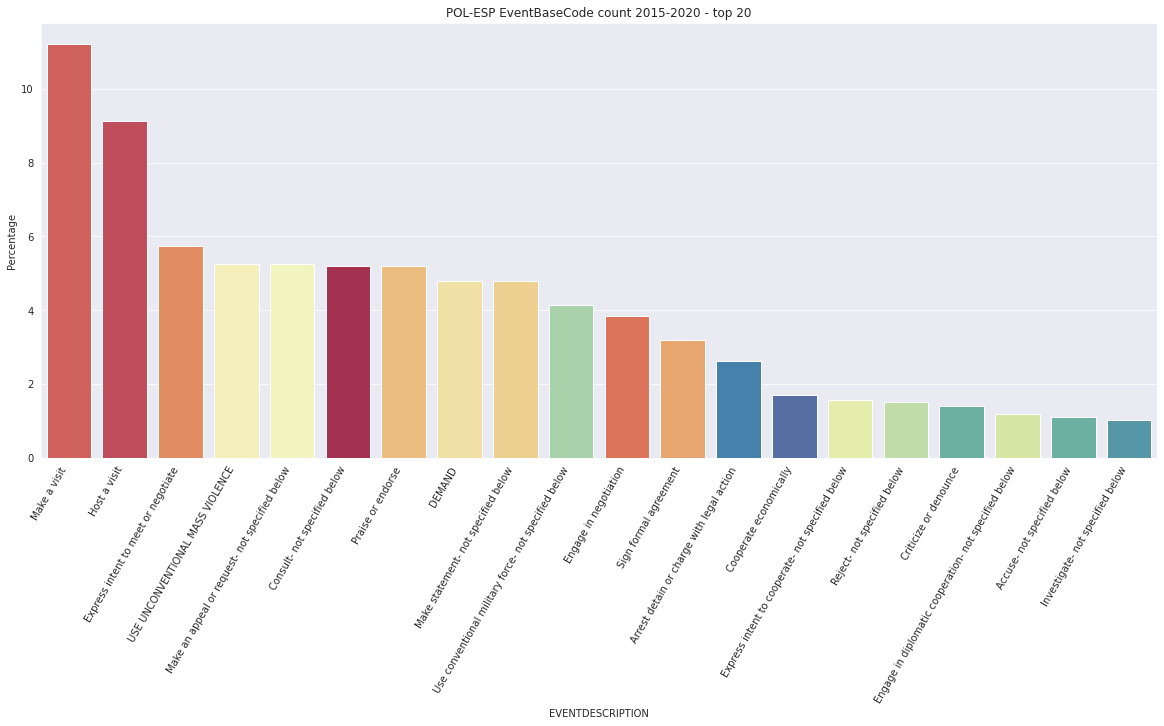

In [32]:
self = []

pairs = [["POL", "CZE"], ["POL", "USA"], ["POL", "RUS"], ["POL", "DEU"], ["POL", "HUN"], ["POL", "ESP"]]
palette = []
code = "EventBaseCode"

for actor1, actor2 in pairs:

    QUERY = (f"""SELECT
      {code},
      COUNT(*) AS Count
    FROM
      `gdelt-bq.gdeltv2.events`
    WHERE
      Year >= 2015
      AND Year <= 2020
      AND Actor1CountryCode = "{actor1}"
      AND Actor2CountryCode = "{actor2}"
    GROUP BY
      {code}""")

    n = 20
    name = f"{actor1}-{actor2} {code} count 2015-2020 - top {n}"

    folder = f"fig_{code}"
    smg = await get_croped_data(QUERY, 20)
    palette = update_palette_for_event_descriptions(palette, smg.EVENTDESCRIPTION)
    save_barplot(folder, name, palette, smg)

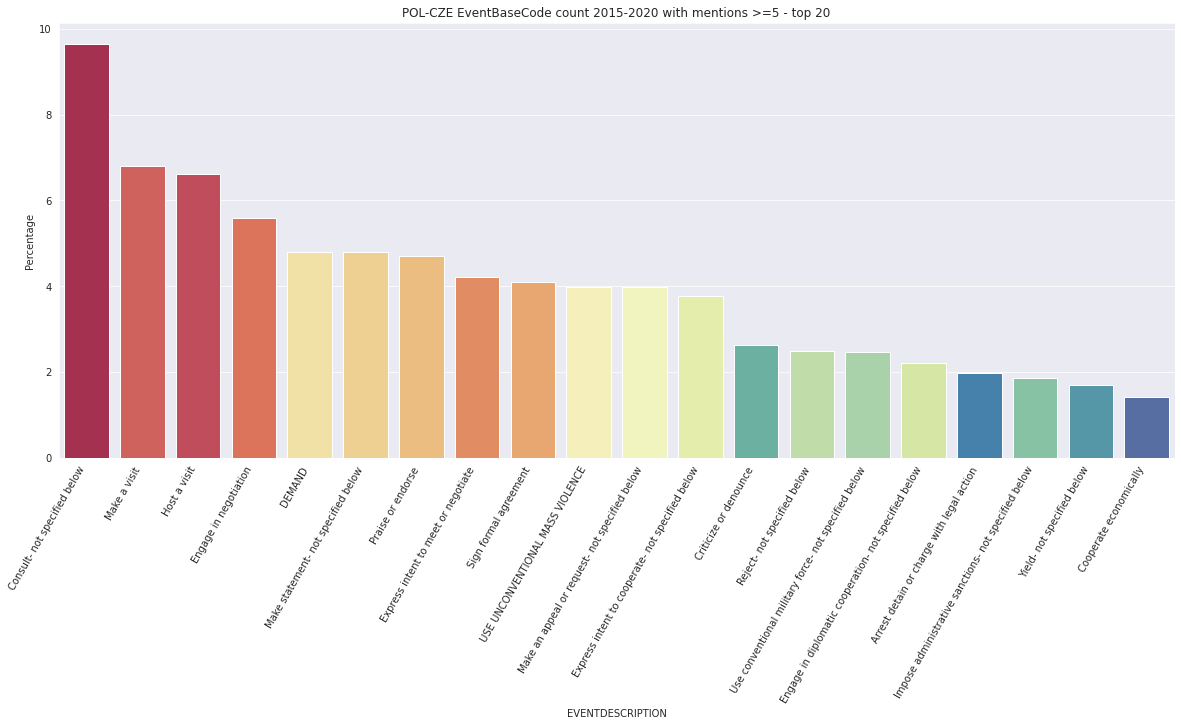

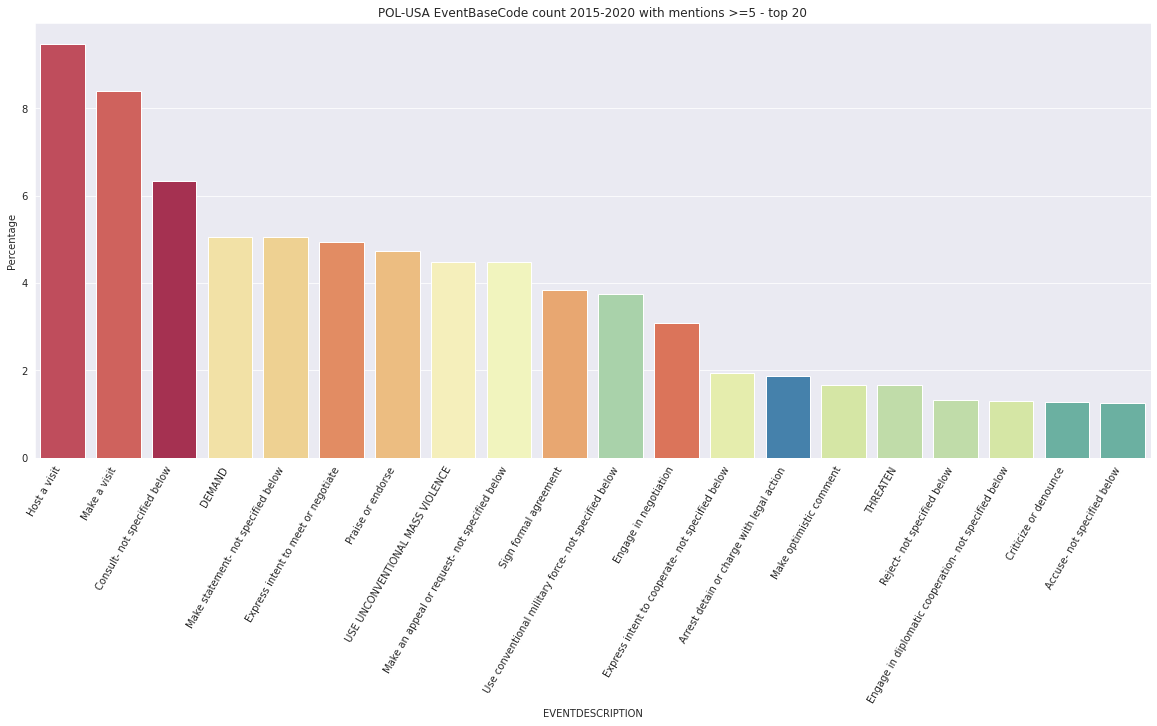

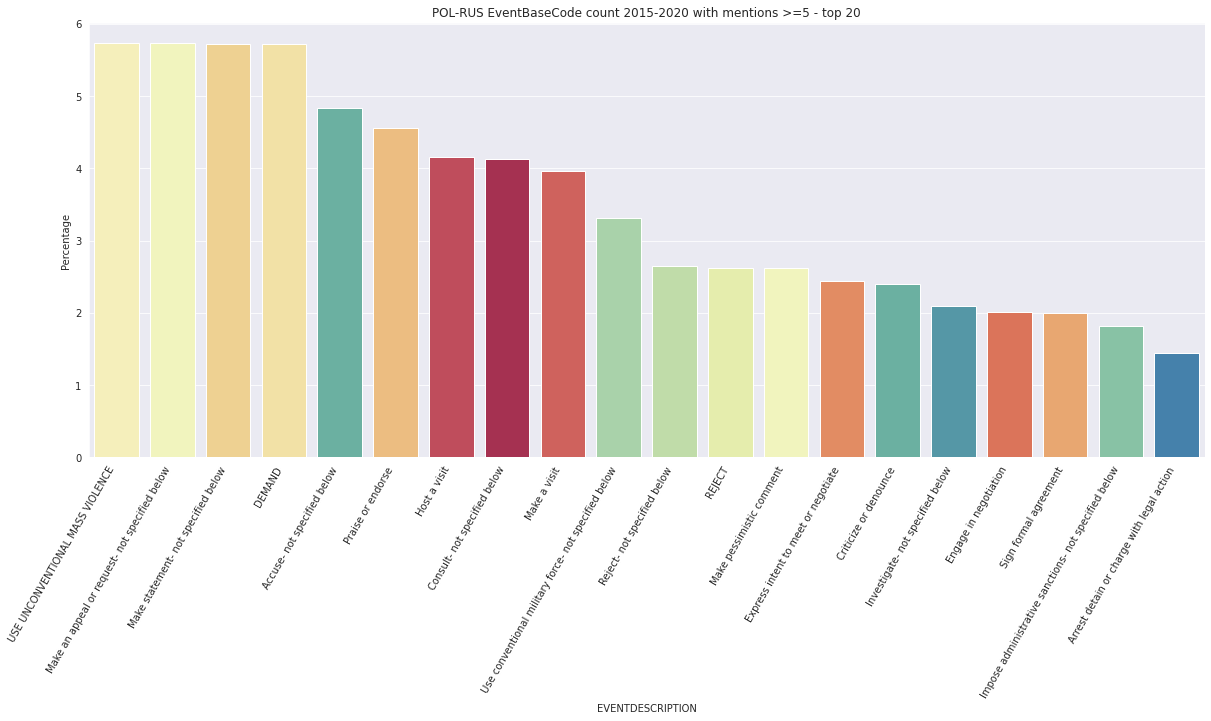

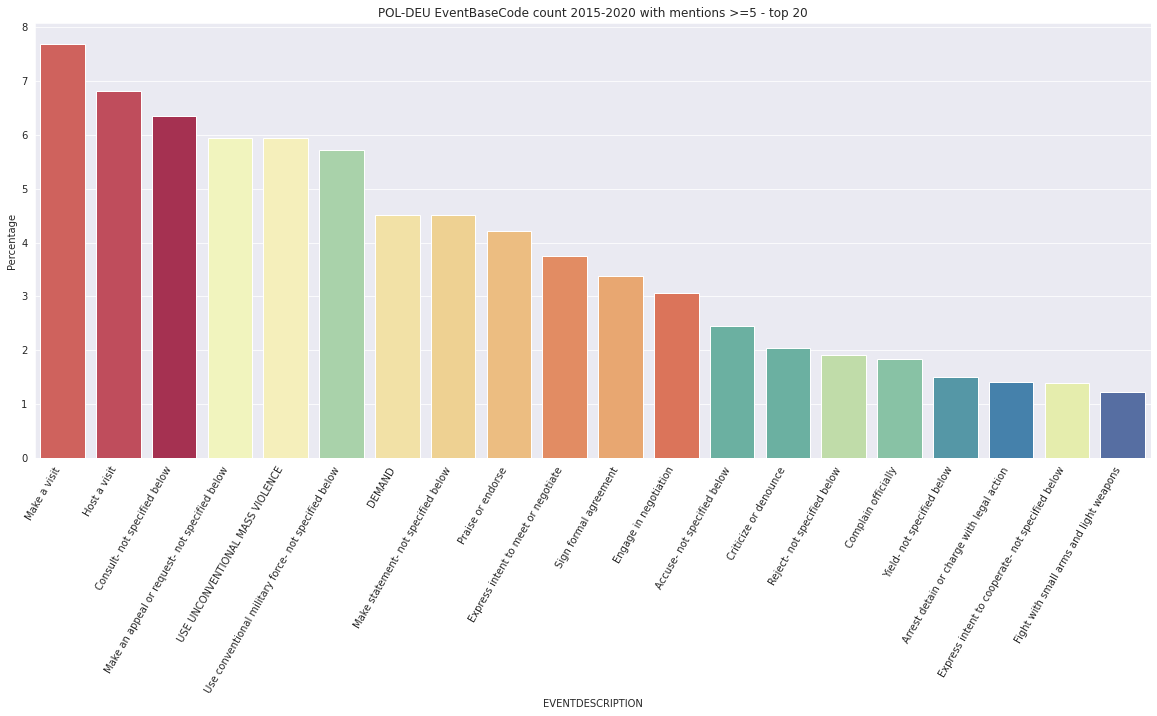

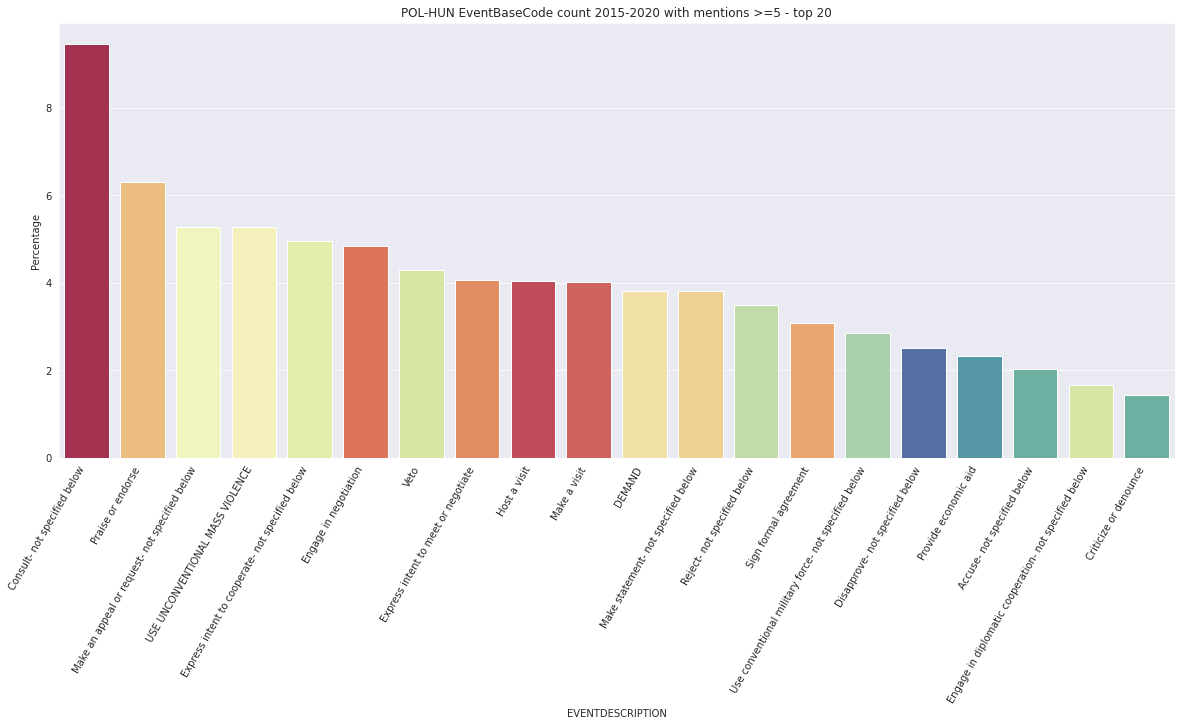

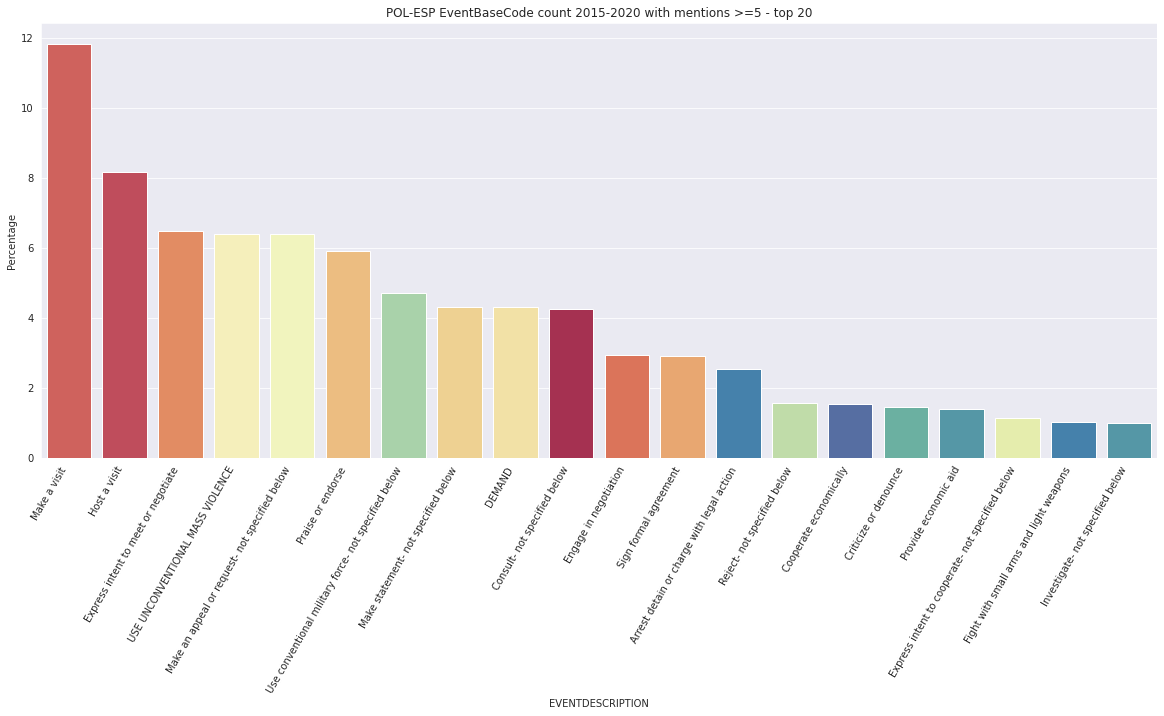

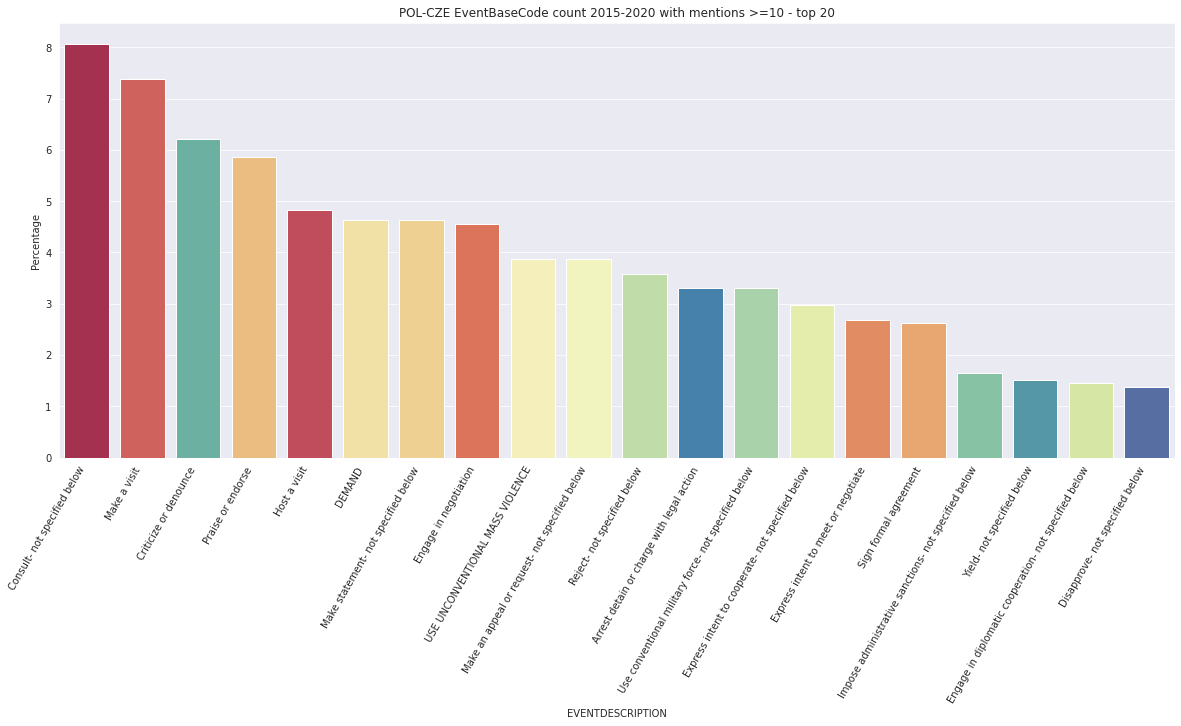

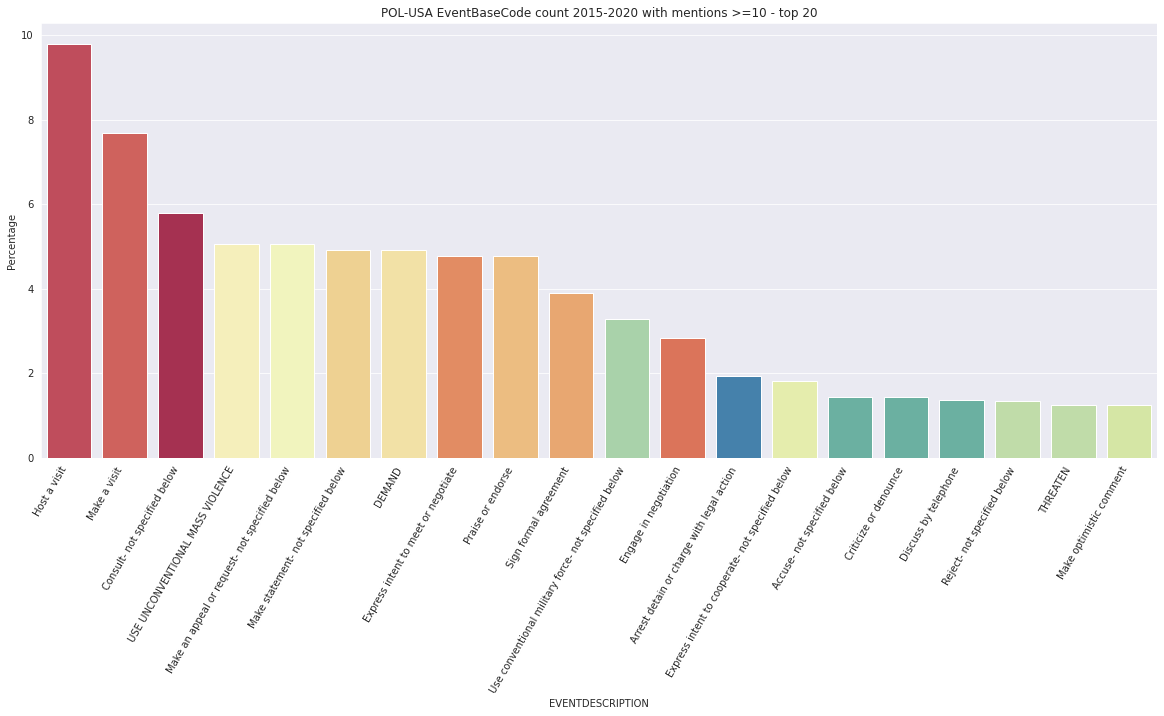

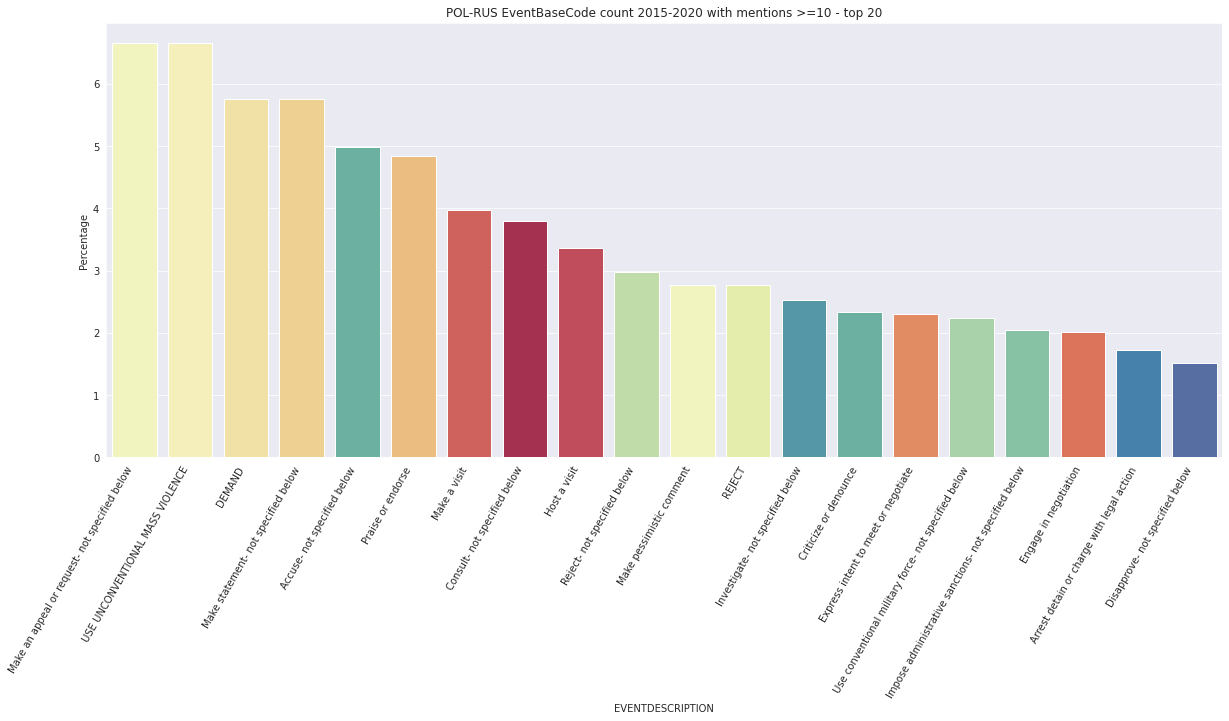

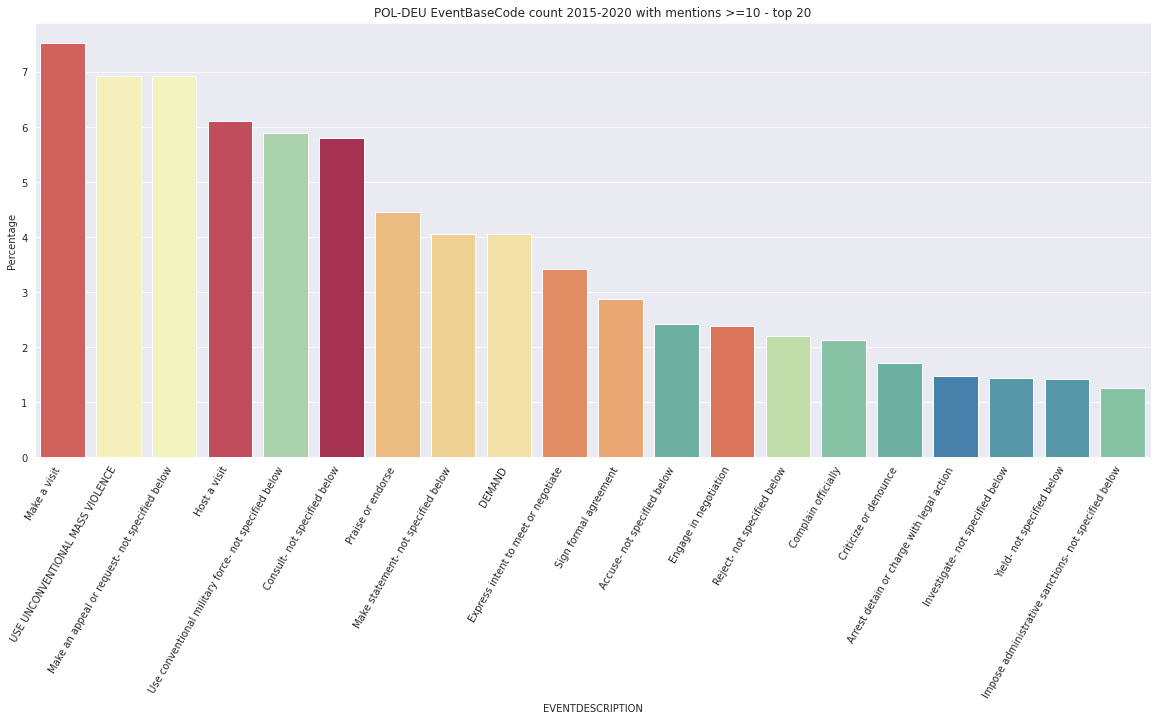

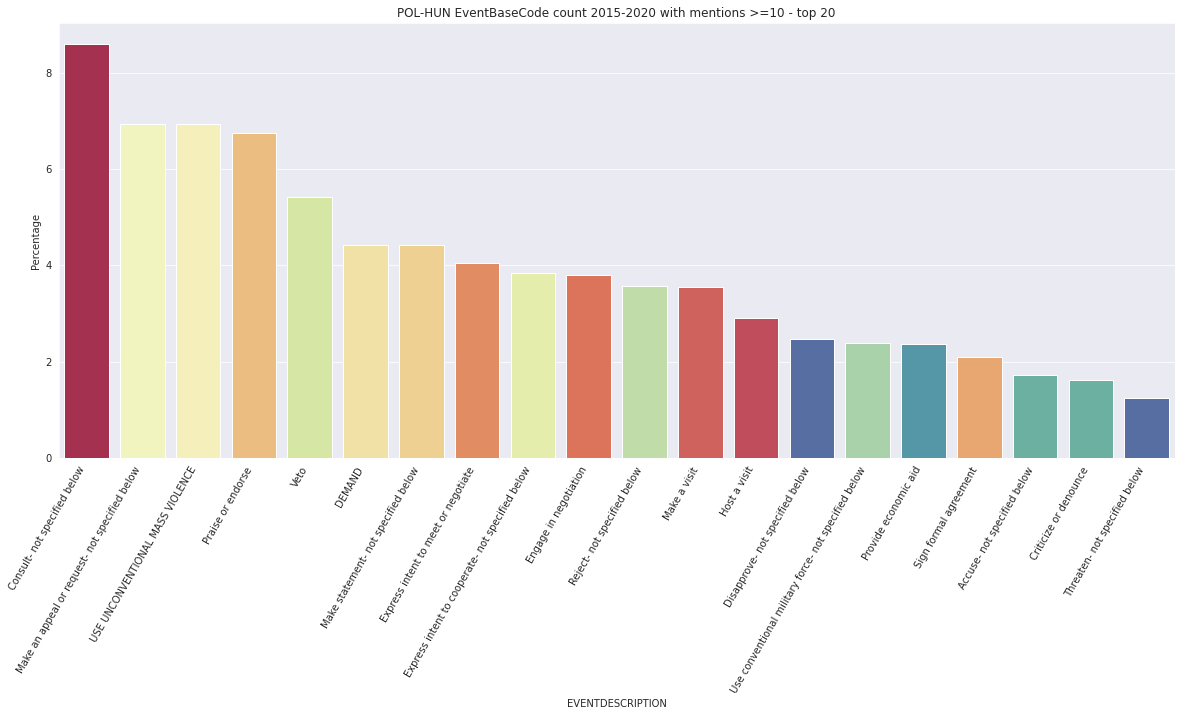

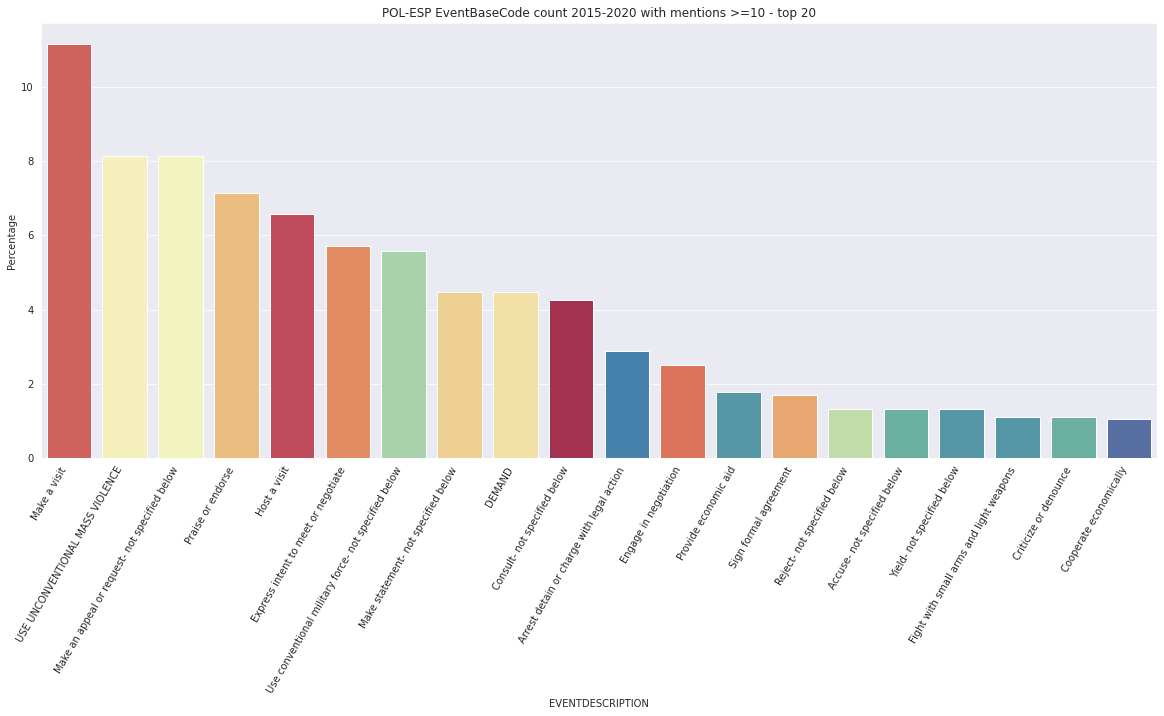

In [33]:
nummens = [5, 10]

for nummen in nummens:
    for actor1, actor2 in pairs:
        QUERY = (f"""SELECT
          {code},
          COUNT(*) AS Count
        FROM
          `gdelt-bq.gdeltv2.events`
        WHERE
          Year >= 2015
          AND Year <= 2020
          AND Actor1CountryCode = "{actor1}"
          AND Actor2CountryCode = "{actor2}"
          AND NumMentions >= {nummen}
        GROUP BY
          {code}""")

        name = f"{actor1}-{actor2} {code} count 2015-2020 with mentions >={nummen} - top {n}"

        smg = await get_croped_data(QUERY, 20)
        palette2 = update_palette_for_event_descriptions(palette, smg.EVENTDESCRIPTION)
        save_barplot(folder, name, palette2, smg)

In [34]:
#######################

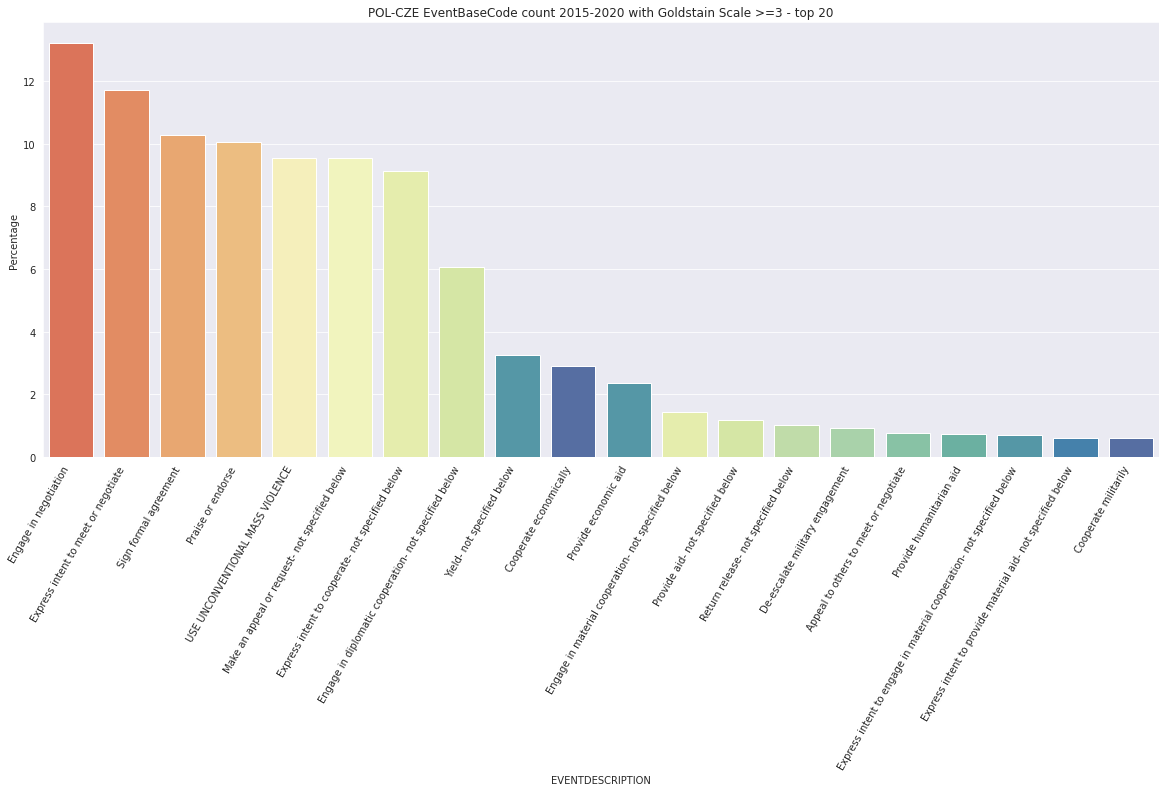

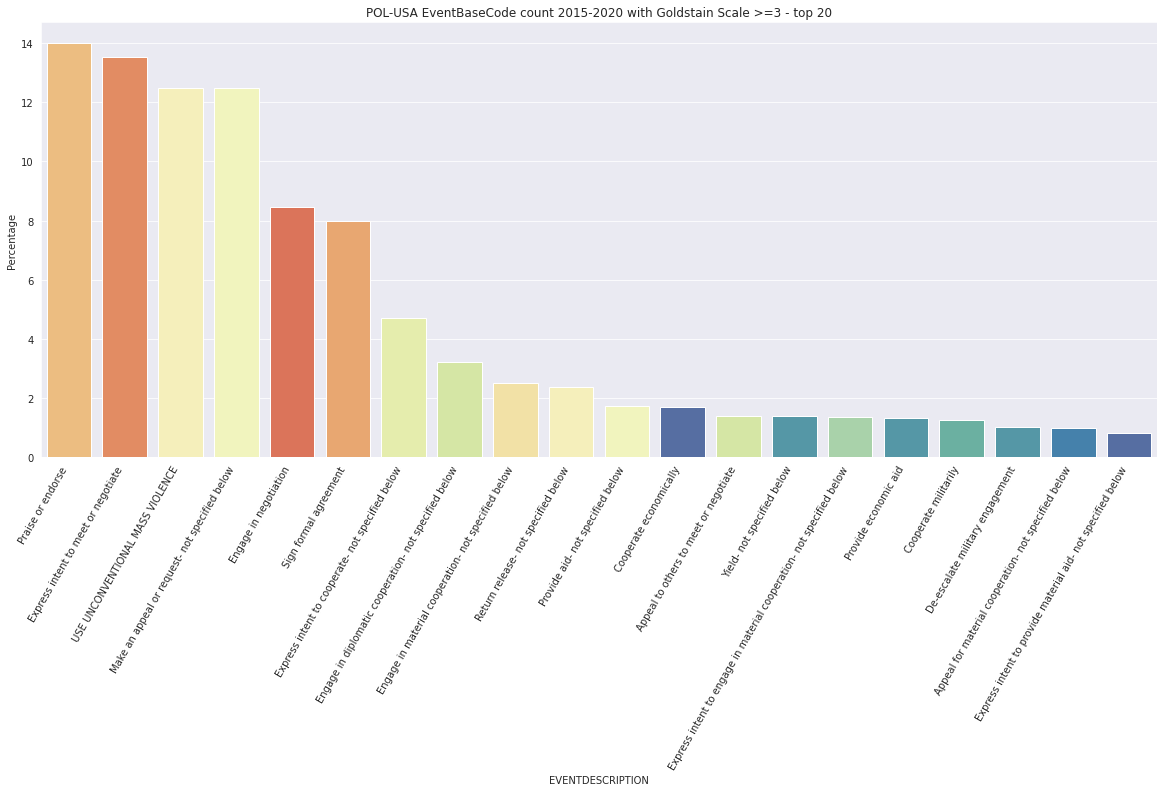

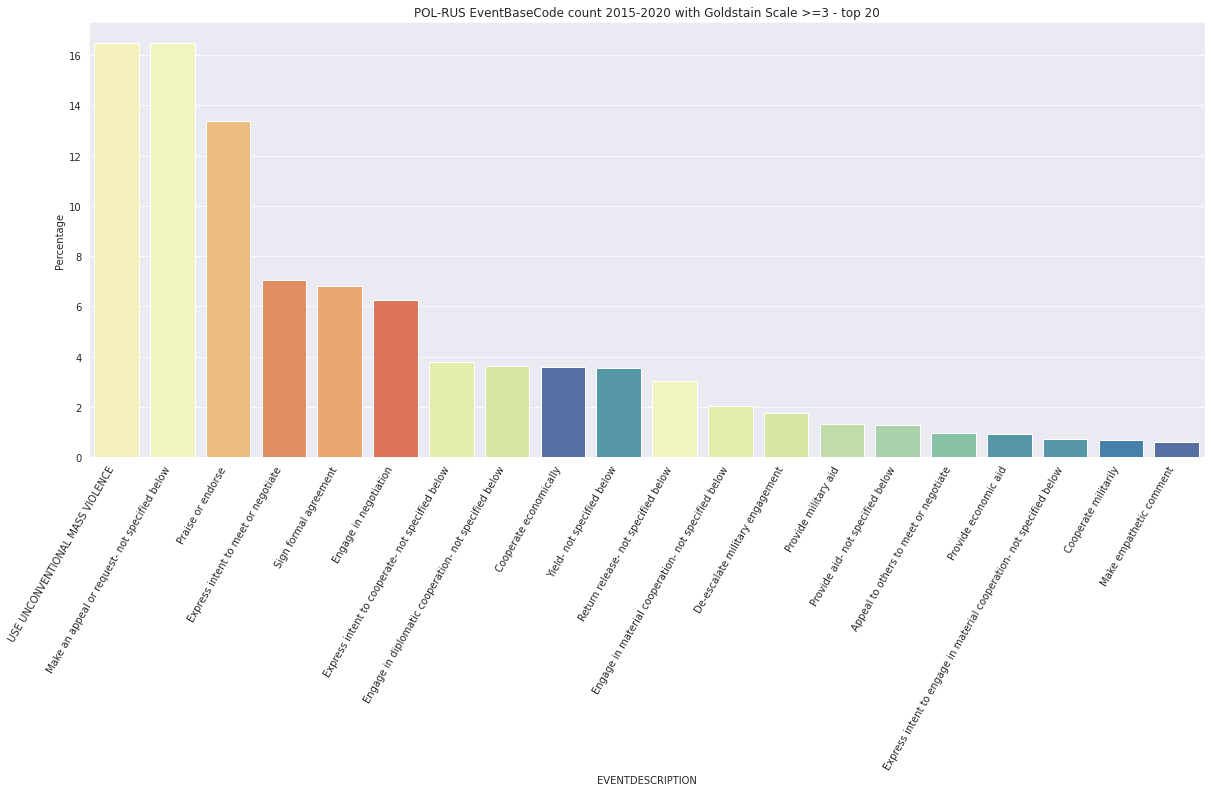

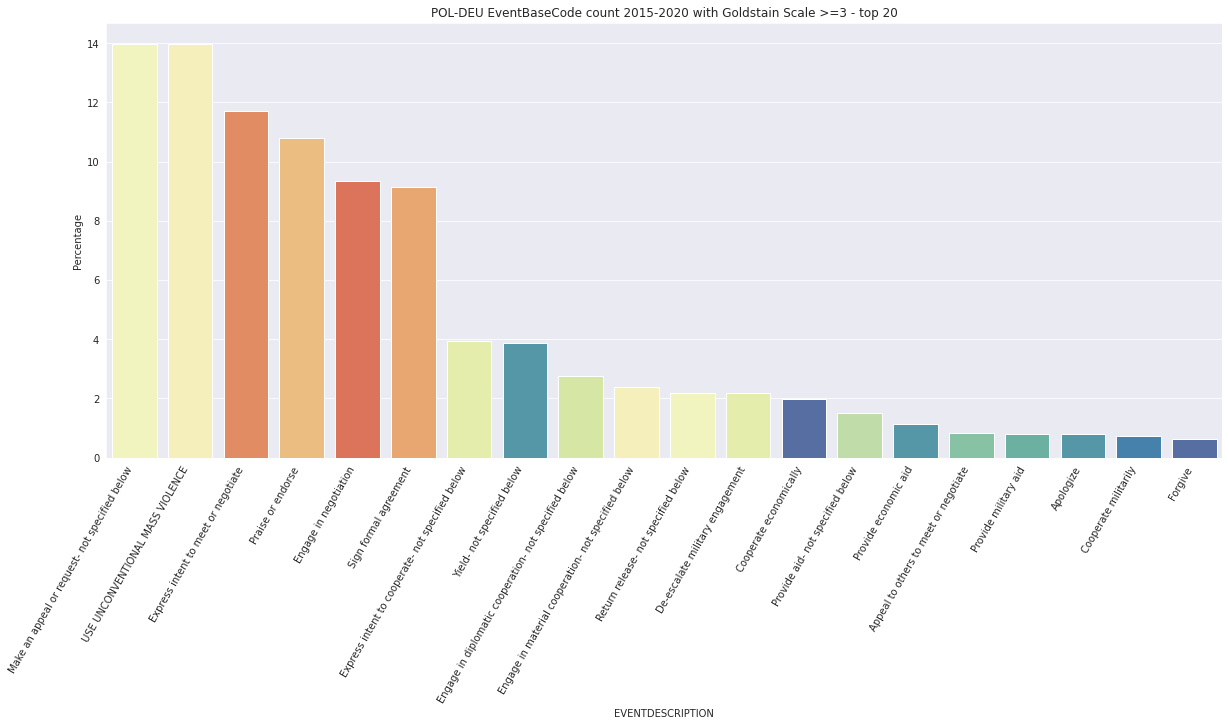

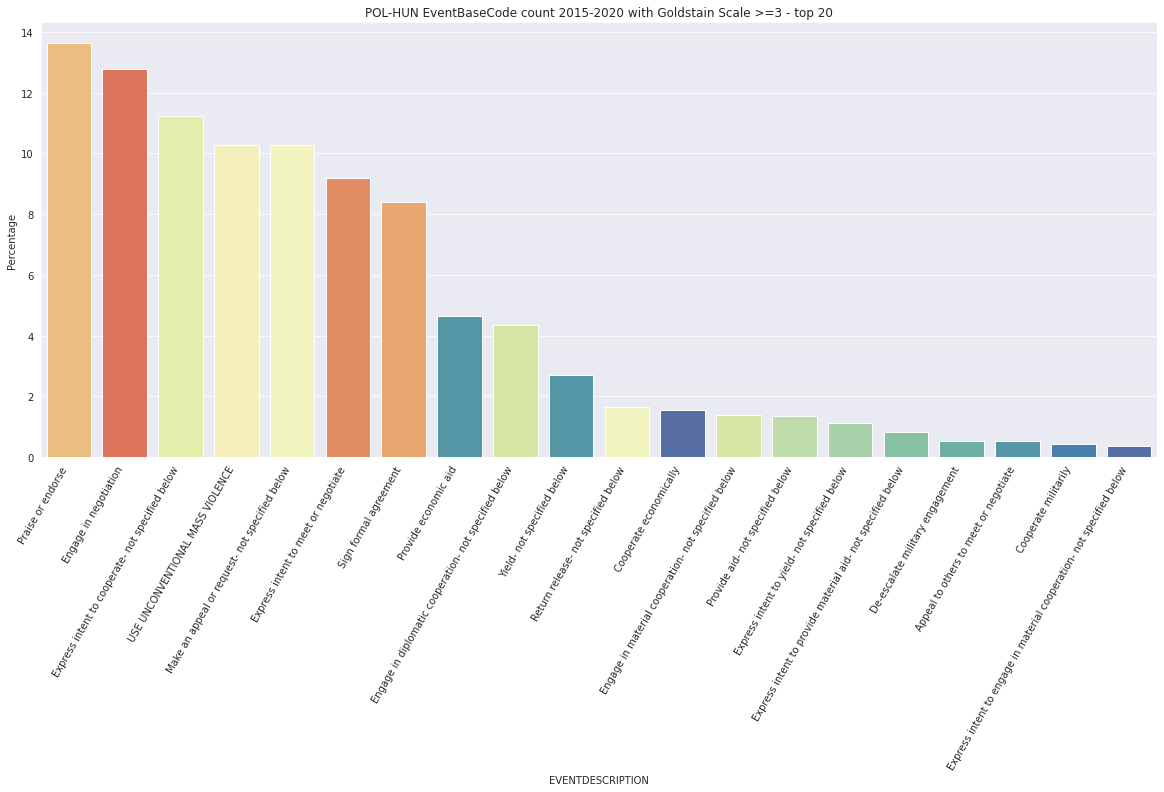

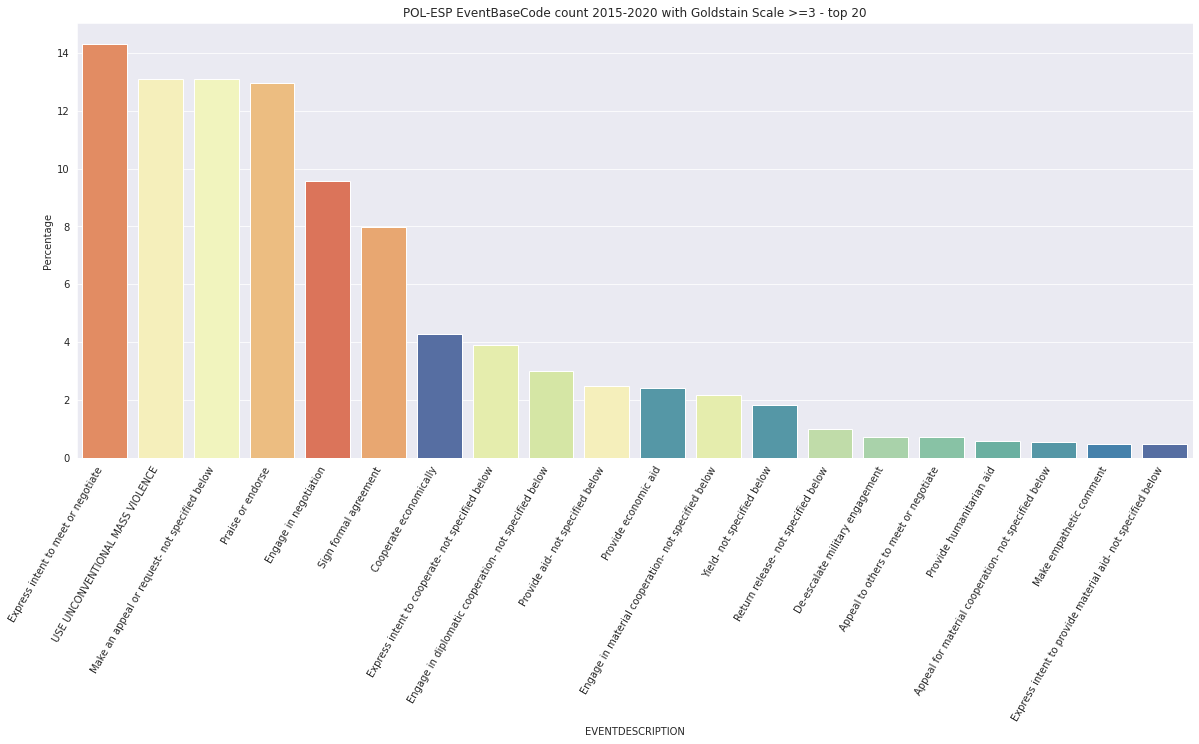

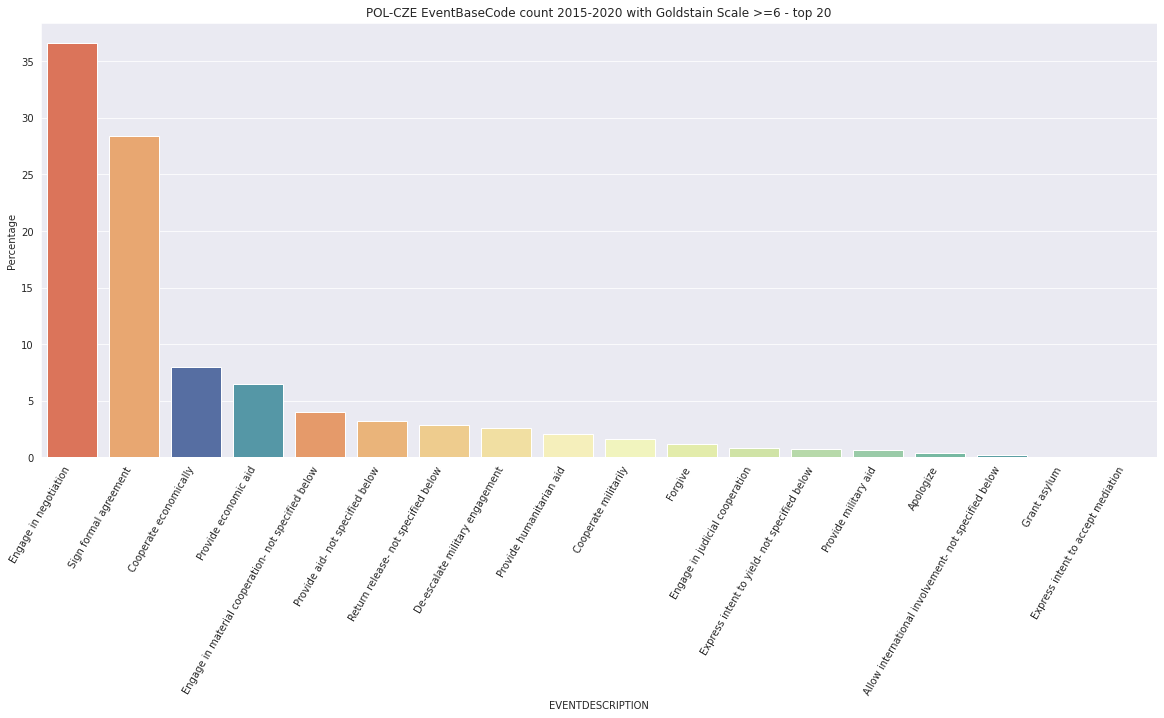

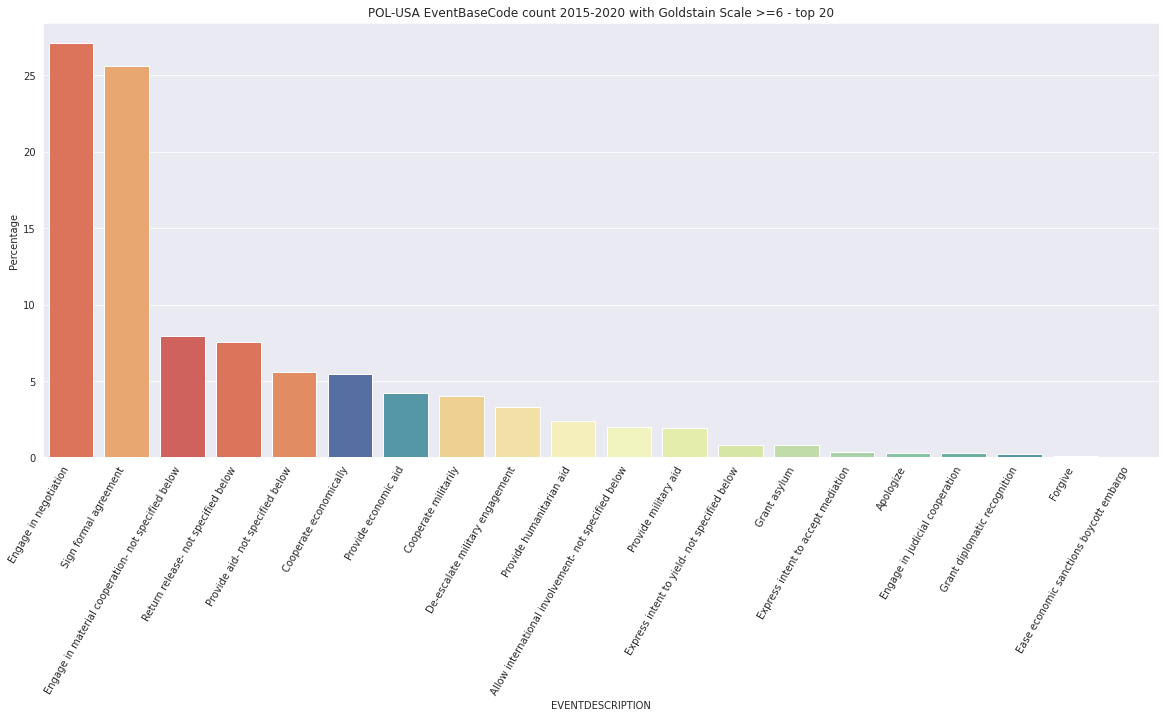

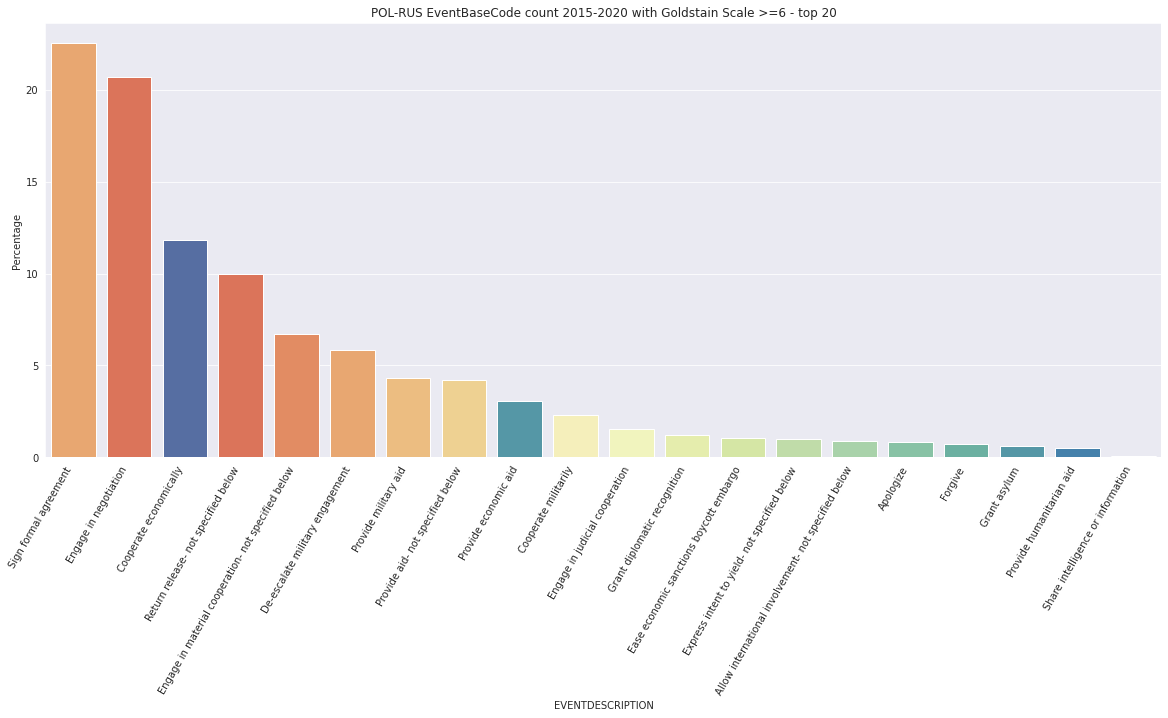

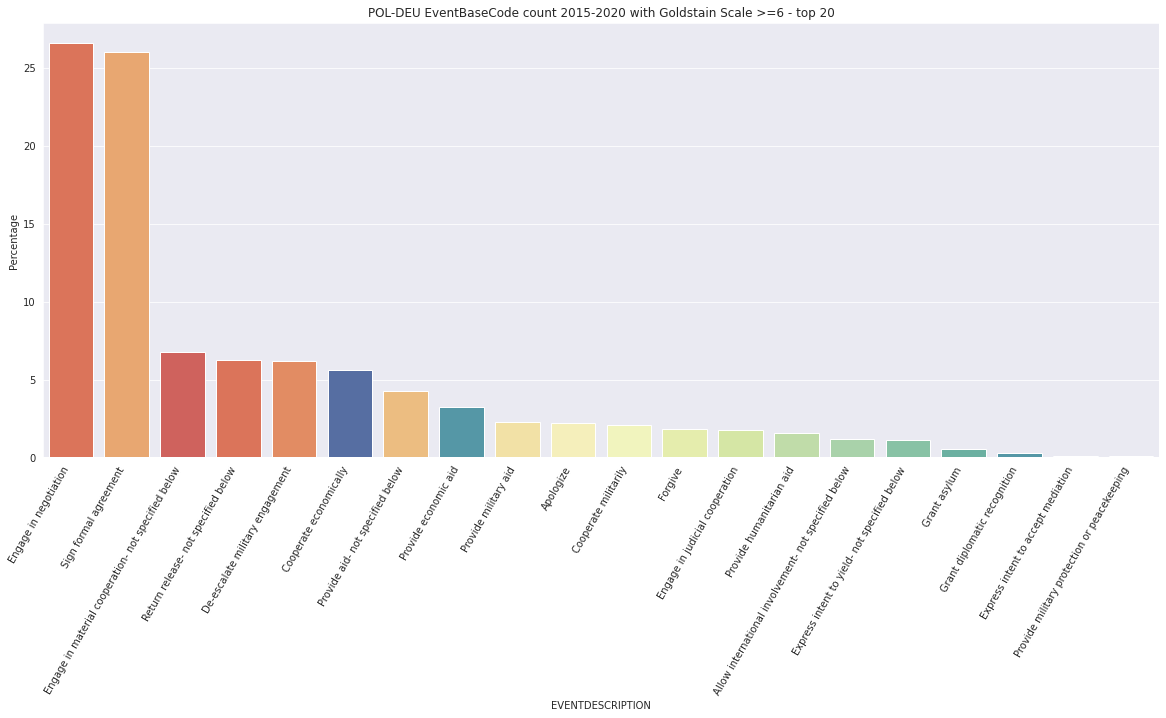

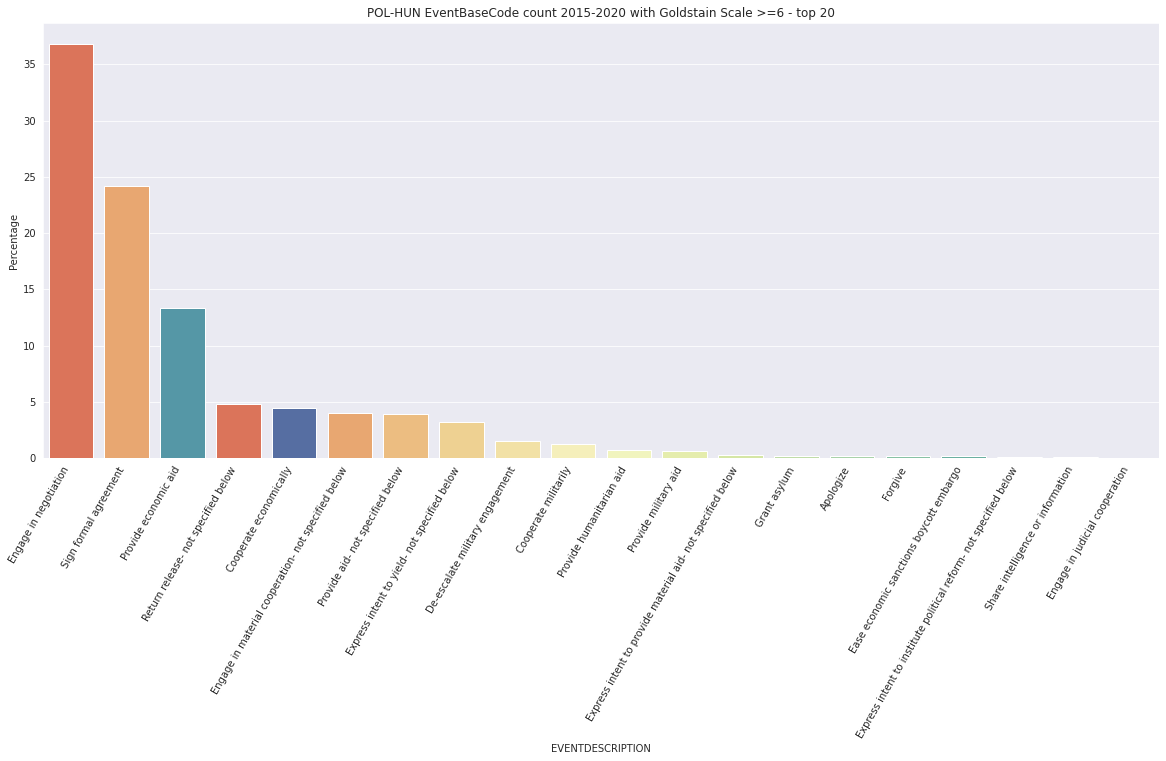

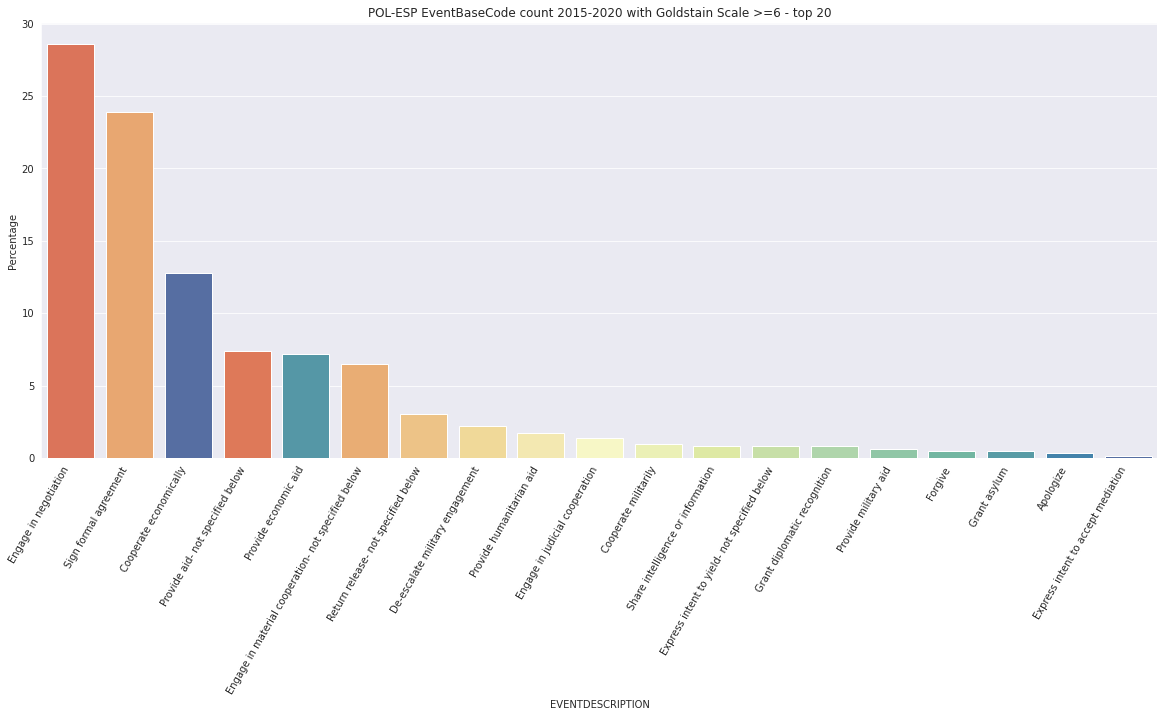

In [35]:
goldsteins = [3, 6]

for gold in goldsteins:
    for actor1, actor2 in pairs:
        QUERY = (f"""SELECT
          {code},
          COUNT(*) AS Count
        FROM
          `gdelt-bq.gdeltv2.events`
        WHERE
          Year >= 2015
          AND Year <= 2020
          AND Actor1CountryCode = "{actor1}"
          AND Actor2CountryCode = "{actor2}"
          AND GoldsteinScale >= {gold}
        GROUP BY
          {code}""")

        name = f"{actor1}-{actor2} {code} count 2015-2020 with Goldstain Scale >={gold} - top {n}"

        smg = await get_croped_data(QUERY, 20)
        palette2 = update_palette_for_event_descriptions(palette, smg.EVENTDESCRIPTION)
        save_barplot(folder, name, palette2, smg)